In [1]:
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed, parallel_backend
from psiam_tied_dv_map_utils_for_noise import psiam_tied_data_gen_wrapper_noise_change_no_L, psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change
import pandas as pd
import random

# Params

In [2]:
# V_A = 1.6
# theta_A = 2.53
V_A = 1.6
theta_A = 2.53

rate_lambda = 0.118
T_0 = 1/2220
theta_E = 45

t_A_aff = -0.187
t_E_aff = 0.075

Z_E = 0

N_sim = int(50e3)
dt = 1e-4

# ABL, ILD, stim and led times from data

In [3]:
# repeat_trial, T16, S7
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]


# t_stim, t_LED, ABL, ILD
t_stim_and_led_tuple = [(row['intended_fix'], row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]
ABL_arr = df['ABL'].unique(); ABL_arr.sort()
ILD_arr = df['ILD'].unique(); ILD_arr.sort()


# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))
# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)


#### LED OFF #####
df_led_off = df[df['LED_trial'] == 0]


### LED ON ###
df_led_on = df[df['LED_trial'] == 1]
df_led_on = df_led_on[df_led_on['LED_powerL'] == df_led_on['LED_powerR']]  # Bilateral, Left and right same power = 100

# simulate

In [4]:
np.random.seed(42)
sampled_indices = np.random.choice(len(t_stim_and_led_tuple), N_sim)
t_stim_and_led_tuple = [t_stim_and_led_tuple[i] for i in sampled_indices]

is_LED_trial = True
new_V_A = V_A + 1.8
new_noise = 80
T0_factor = 2.1
N_print = int(N_sim/5)

# Increase T0 -> dec  mu and sigma, add noise
sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff,\
                                                                                    t_stim_and_led_tuple[iter_num], new_V_A, new_noise, T0_factor, iter_num, N_print, is_LED_trial, dt) for iter_num in range(N_sim))


sim_results_df = pd.DataFrame(sim_results)
sim_results_df['correct'] = (sim_results_df['ILD'] * sim_results_df['choice']).apply(lambda x: 1 if x > 0 else 0)

os id: 324402, In iter_num: 0, ABL: 60, ILD: 8.0, t_stim: 0.479616722682289
os id: 324410, In iter_num: 10000, ABL: 60, ILD: 2.0, t_stim: 0.261591017183307
os id: 324410, In iter_num: 20000, ABL: 20, ILD: 1.0, t_stim: 0.777913584573004
os id: 324460, In iter_num: 30000, ABL: 40, ILD: -16.0, t_stim: 1.28147530072172
os id: 324456, In iter_num: 40000, ABL: 60, ILD: -1.0, t_stim: 0.202277061744796


# with aborts and without aborts

In [5]:
### data ###
# aborts > 0.3 OR success
data_df_led_on_with_aborts_0 = df_led_on[ ((df_led_on['abort_event'] == 3) & (df_led_on['timed_fix'] > 0.3))  | (df_led_on['success'].isin([1,-1]))  ]
# NO RT - t_stim > 1
data_df_led_on_with_aborts = data_df_led_on_with_aborts_0[data_df_led_on_with_aborts_0['timed_fix'] - data_df_led_on_with_aborts_0['intended_fix'] < 1] 
data_df_led_on_with_aborts = data_df_led_on_with_aborts.rename(
                                        columns={'intended_fix': 't_stim', 'timed_fix': 'rt'}
                                    )

data_df_led_on_valid = data_df_led_on_with_aborts[data_df_led_on_with_aborts['success'].isin([1,-1])]


### sim ###
# remove left outliers: aborts < 0.3
sim_results_df_with_aborts_0 = sim_results_df[~((sim_results_df['rt'] < sim_results_df['t_stim']) & (sim_results_df['rt'] < 0.3))  ]
# remove right outliers: timed - fix > 1
sim_results_df_with_aborts = sim_results_df_with_aborts_0[sim_results_df_with_aborts_0['rt'] - sim_results_df_with_aborts_0['t_stim'] < 1]
# valid trials
sim_results_df_valid = sim_results_df_with_aborts[sim_results_df_with_aborts['rt'] > sim_results_df_with_aborts['t_stim']]

In [6]:
# Filter valid trials and then check for response_poke not in [3,2]
filtered = data_df_led_on_valid[(data_df_led_on_valid['rt'] > data_df_led_on_valid['t_stim']) &
                                (~data_df_led_on_valid['response_poke'].isin([3, 2]))]

# Print the relevant columns
print(filtered[['response_poke', 'rt', 't_stim']])


Empty DataFrame
Columns: [response_poke, rt, t_stim]
Index: []


Text(0, 0.5, 'density')

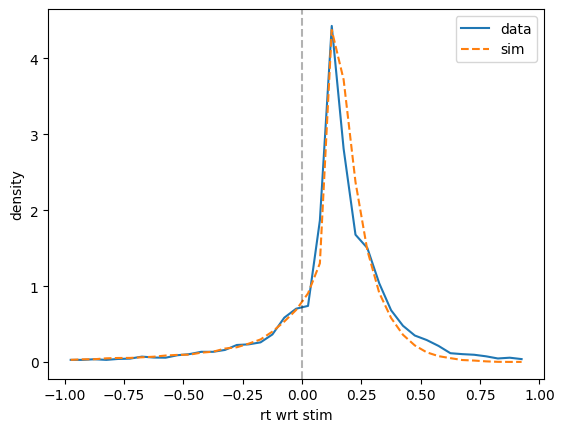

In [7]:
bins = np.arange(-1,1,0.05)
bin_centers = (bins[1:] + bins[:-1])/2

data_hist, _ = np.histogram(data_df_led_on_with_aborts['rt'] - data_df_led_on_with_aborts['t_stim'], bins=bins, density=True)
sim_hist, _ = np.histogram(sim_results_df_with_aborts['rt'] - sim_results_df_with_aborts['t_stim'], bins=bins, density=True)


plt.plot(bin_centers, data_hist, label='data')
plt.plot(bin_centers, sim_hist, label='sim', ls='--')
plt.axvline(0, color='k', ls='--', alpha=0.3)
plt.legend()
plt.xlabel('rt wrt stim')
plt.ylabel('density')

# diagnostics

In [8]:
from diagnostics_class import Diagnostics

sim_diag_with_aborts = Diagnostics(sim_results_df_with_aborts)
data_diag_with_aborts = Diagnostics(data_df_led_on_with_aborts)

sim_diag_valid = Diagnostics(sim_results_df_valid)
data_diag_valid = Diagnostics(data_df_led_on_valid)

# design diagnostics v3

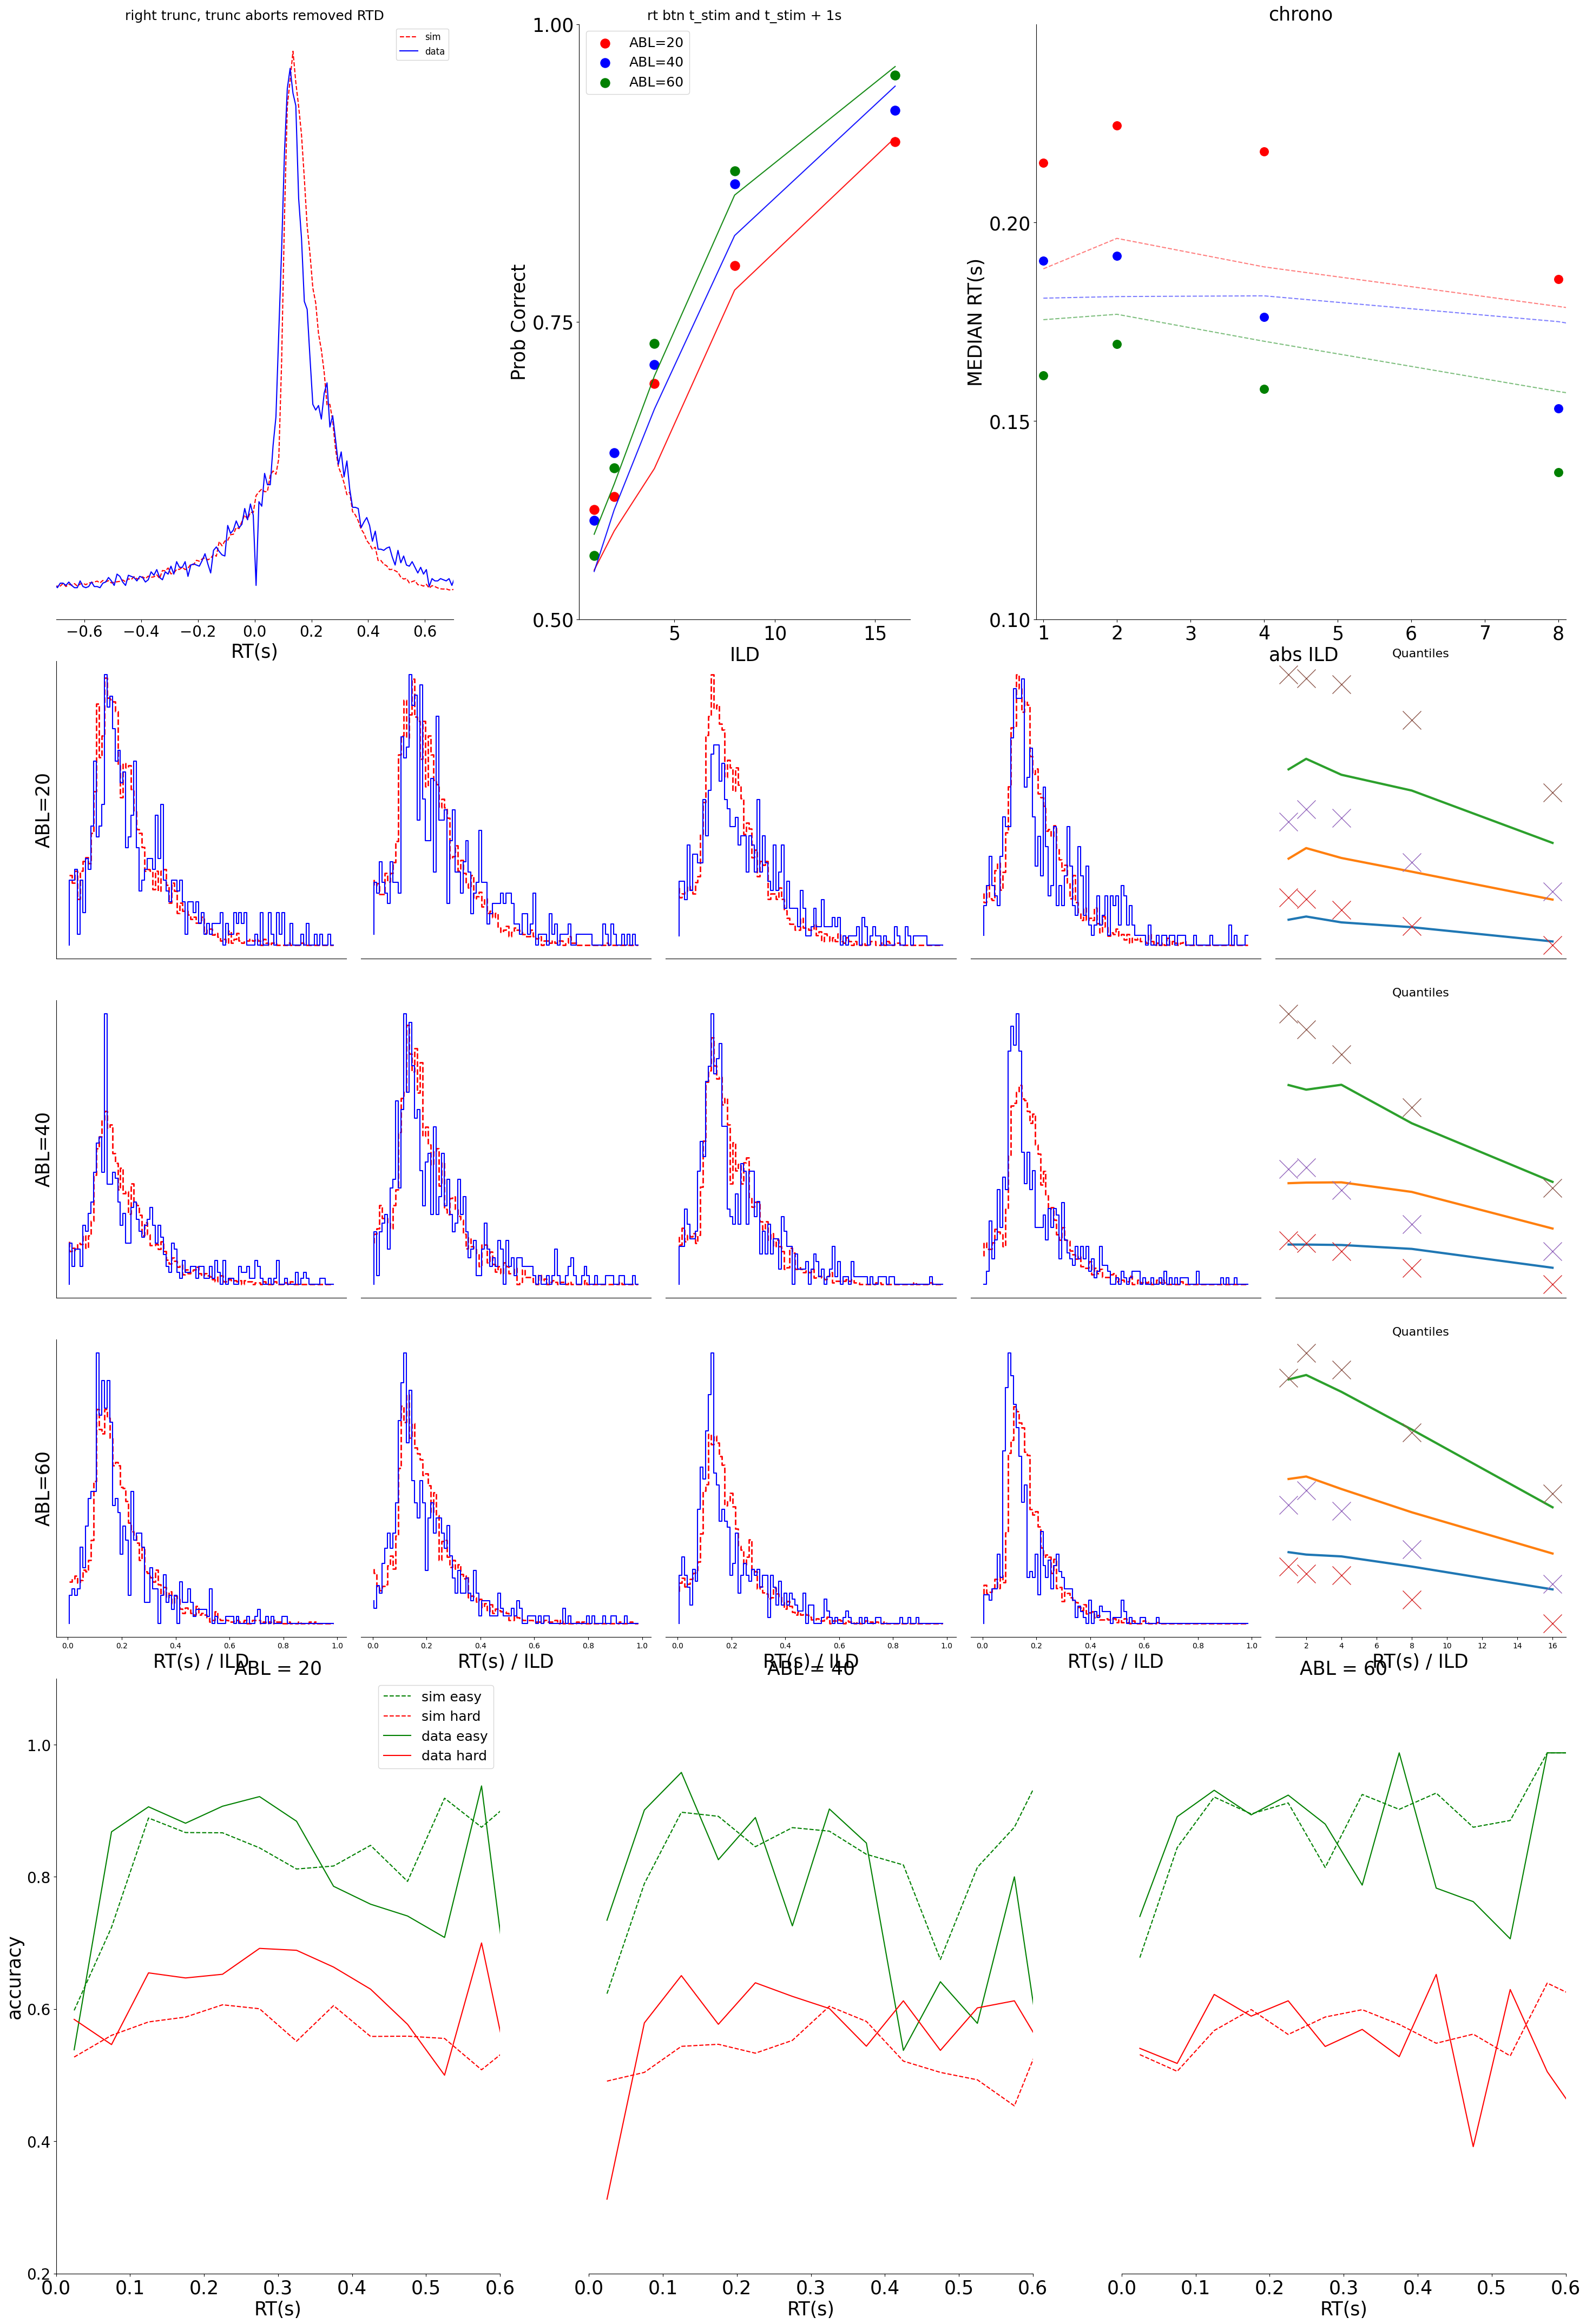

In [9]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(12*3, 18*3))
gs = GridSpec(nrows=5, ncols=5, figure=fig, hspace=0.1, wspace=0.05, height_ratios=[1, 0.5, 0.5, 0.5, 1])


# Create a sub‐GridSpec for row=0, spanning all columns
top_gs = gs[0, :]  # entire top row
top_subgs = GridSpecFromSubplotSpec(
    1, 3,                      # 1 row × 3 columns
    subplot_spec=top_gs,       # link to the main row=0
    width_ratios=[1.2, 1, 1.6],
    wspace=0.3              # horizontal spacing
)

# Make three subplots from top_subgs
ax_rtd     = fig.add_subplot(top_subgs[0, 0])
ax_psy     = fig.add_subplot(top_subgs[0, 1])
ax_chrono  = fig.add_subplot(top_subgs[0, 2])



ABL_colors = {20: 'r', 40: 'b', 60: 'g'}
ILD_colors = {1: 'r', 2: 'b', 4: 'g', 8: 'm', 16: 'k'}

### Grand RTD ###
bins = np.arange(-1, 1, 0.01)
x, y = sim_diag_with_aborts.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='sim', ls='--', color='r')

x, y = data_diag_with_aborts.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='data', color='b')

ax_rtd.set_title('right trunc, trunc aborts removed RTD', fontsize=18)
ax_rtd.set_xlabel('RT(s)', fontsize=25)
ax_rtd.tick_params(axis='both', which='major', labelsize=20)
ax_rtd.legend(fontsize=12)
ax_rtd.spines['top'].set_visible(False)
ax_rtd.spines['right'].set_visible(False)
ax_rtd.spines['left'].set_visible(False)
ax_rtd.set_yticks([])
ax_rtd.spines['bottom'].set_visible(True)
ax_rtd.set_xlim(-0.7, 0.7)
### END of Grand RTD ###

### Accuracy vs abs ILD ###
data_psycho = data_diag_valid.plot_correct_vs_abs_ILD()
all_ABL = data_psycho.keys()
all_ILD = np.sort(df['ILD'].unique())
all_pos_ILD = list(set(np.abs(df['ILD'].unique())))

sim_psycho = sim_diag_valid.plot_correct_vs_abs_ILD()
for ABL in all_ABL:
    ax_psy.scatter(all_pos_ILD, data_psycho[ABL], label=f'ABL={ABL}', color=ABL_colors[ABL], s=150)
    ax_psy.plot(all_pos_ILD, sim_psycho[ABL], alpha=0.9, color=ABL_colors[ABL])

ax_psy.set_xlabel('ILD', fontsize=25)
ax_psy.set_ylabel('Prob Correct', fontsize=25)
ax_psy.set_title('rt btn t_stim and t_stim + 1s', fontsize=18)
ax_psy.legend(fontsize=18)
ax_psy.spines['top'].set_visible(False)
ax_psy.spines['right'].set_visible(False)
ax_psy.spines['left'].set_visible(True)
ax_psy.spines['bottom'].set_visible(True)
ax_psy.tick_params(axis='x', which='major', labelsize=25)
ax_psy.tick_params(axis='y', which='major', labelsize=25)
ax_psy.set_yticks([0.5,0.75, 1.0])
### END of Accuracy vs abs ILD ###



### Chrono ###
x, sim_chrono = sim_diag_valid.plot_chrono_median()
for ABL in sim_chrono.keys():
    ax_chrono.plot(x, sim_chrono[ABL], color=ABL_colors[ABL], alpha=0.5, ls='--')

x, data_chrono = data_diag_valid.plot_chrono_median()
for ABL in data_chrono.keys():
    ax_chrono.scatter(x, data_chrono[ABL], label=f'data ABL={ABL}', color=ABL_colors[ABL], marker='.', s=500)
# ax_chrono.legend(fontsize=18) # psycho covers it
ax_chrono.set_xlabel(' abs ILD', fontsize=25)
ax_chrono.set_ylabel('MEDIAN RT(s)', fontsize=25)
ax_chrono.set_title('chrono', fontsize=25)
ax_chrono.set_ylim(0, 0.4)
ax_chrono.spines['top'].set_visible(False)
ax_chrono.spines['right'].set_visible(False)
ax_chrono.spines['left'].set_visible(True)
ax_chrono.spines['bottom'].set_visible(True)
ax_chrono.tick_params(axis='both', which='both', labelsize=25)
ax_chrono.set_ylim(0.1, 0.25)
ax_chrono.set_xlim(0.9, 8.1)
ax_chrono.set_yticks(np.arange(0.1, 0.25, 0.05))
### END of Chrono ###

### RTDs per ABL ###
# Get all positive ILDs (do not exclude the last one)
# Precompute quantile dictionaries using the provided function
sim_quantiles = sim_diag_valid.plot_quantile()  # {ABL: {ILD: [q10, q30, q50, q70, q90]}}
data_quantiles = data_diag_valid.plot_quantile()

# Get all positive ILDs (do not drop the last one)
bins = np.arange(0, 1, 0.01)

for a, ABL in enumerate(ABL_arr):
    row = a + 1
    for j, ILD in enumerate(all_pos_ILD):
        ax = fig.add_subplot(gs[row, j])
        
        # For all but the last column, plot the histograms for that abs ILD
        if j < len(all_pos_ILD) - 1:
            # Filter for current ABL and ILD (both signs)
            sim_pd = sim_results_df_valid[(sim_results_df_valid['ABL'] == ABL) & (sim_results_df_valid['ILD'].isin([ILD, -ILD]))]
            sim_rt = sim_pd['rt'] - sim_pd['t_stim']
            
            data_pd = data_df_led_on_valid[(data_df_led_on_valid['ABL'] == ABL) & (data_df_led_on_valid['ILD'].isin([ILD, -ILD]))]
            data_rt = data_pd['rt'] - data_pd['t_stim']
            
            sim_rt_hist, _ = np.histogram(sim_rt, density=True, bins=bins)
            data_rt_hist, _ = np.histogram(data_rt, density=True, bins=bins)
            t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])
            
            ax.step(t_pts, sim_rt_hist, linestyle='dashed', color='r', label='sim', linewidth=2)
            ax.step(t_pts, data_rt_hist, label=f'data ILD={ILD}', color='b')
        
        else:
            sim_qs = [sim_quantiles[ABL][ild] for ild in all_pos_ILD]
            data_qs = [data_quantiles[ABL][ild] for ild in all_pos_ILD]

            sim_qs = np.array(sim_qs)
            data_qs = np.array(data_qs)

            ax.plot(all_pos_ILD, sim_qs, lw=3)
            ax.plot(all_pos_ILD, data_qs, linestyle='', marker='x', markersize=25)
            ax.set_title('Quantiles', fontsize=16)
        
        # Common formatting for each subplot
        if a == len(ABL_arr) - 1:
            ax.set_xlabel('RT(s) / ILD', fontsize=25)
        if j == 0:
            ax.set_ylabel(f'ABL={ABL}', fontsize=25)
            ax.tick_params(axis='y', which='major', labelsize=20)
        
        # Format spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        if j != 0:
            ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        
        # Hide x-ticks for non-bottom rows
        if a < len(ABL_arr) - 1:
            ax.set_xticks([])


## END OF RTDs per ABL ### 

### Tachos per ABL ###
# --- Bottom row (row=4) => sub‐GridSpec 1×3 ---
bottom_gs = GridSpecFromSubplotSpec(
    1, 3, 
    subplot_spec=gs[4, 0:5],  # entire last row, columns 0..4
    wspace=0.2,
)

# “Blank” top sub‐row
ax_spacer = fig.add_subplot(bottom_gs[0, :])
ax_spacer.axis("off") 

ax_tacho_20 = fig.add_subplot(bottom_gs[0, 0])
ax_tacho_40 = fig.add_subplot(bottom_gs[0, 1])
ax_tacho_60 = fig.add_subplot(bottom_gs[0, 2])

ax_list  = [ax_tacho_20, ax_tacho_40, ax_tacho_60]

hard_ILD = np.array([1, 2, 4, -1, -2, -4]); easy_ILD = np.array([8, 16, -8, -16])
bins = np.arange(0, 1, 0.05)
for a, ABL in enumerate(ABL_arr):
    ax_r = ax_list[a]

    # sim - easy
    sim_pd_easy = sim_results_df_valid[(sim_results_df_valid['ABL'] == ABL) & (sim_results_df_valid['ILD'].isin(easy_ILD))]
    sim_pd_easy_diag = Diagnostics(sim_pd_easy)
    x, sim_easy_tacho = sim_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, sim_easy_tacho, linestyle='dashed', label='sim easy', color='g')
    
    # sim - hard
    sim_pd_hard = sim_results_df_valid[(sim_results_df_valid['ABL'] == ABL) & (sim_results_df_valid['ILD'].isin(hard_ILD))]
    sim_pd_hard_diag = Diagnostics(sim_pd_hard)
    x, sim_hard_tacho = sim_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, sim_hard_tacho, label='sim hard', color='r', linestyle='dashed')

    # data - easy
    data_pd_easy = data_df_led_on_valid[ (data_df_led_on_valid['ABL'] == ABL) & (data_df_led_on_valid['ILD'].isin(easy_ILD))]
    data_pd_easy_diag = Diagnostics(data_pd_easy)
    x, data_easy_tacho = data_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, data_easy_tacho, label='data easy', color='g')

    # data - hard
    data_pd_hard = data_df_led_on_valid[ (data_df_led_on_valid['ABL'] == ABL) & (data_df_led_on_valid['ILD'].isin(hard_ILD))]
    data_pd_hard_diag = Diagnostics(data_pd_hard)
    x, data_hard_tacho = data_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, data_hard_tacho, label='data hard', color='r')

    ax_r.set_title(f'ABL = {ABL}', fontsize=25)
    ax_r.set_xlabel('RT(s)', fontsize=25)
    if a == 0:
        ax_r.legend(fontsize=18)
        ax_r.set_ylabel('accuracy', fontsize=25)

    ax_r.set_xlim(0, 0.6)
    ax_r.set_ylim(0.3, 1.1)
    ax_r.spines['top'].set_visible(False)
    ax_r.spines['right'].set_visible(False)
    ax_r.spines['left'].set_visible(True)
    ax_r.spines['bottom'].set_visible(True)
    if a == 0:
        ax_r.set_yticks(np.arange(0.2, 1.2, 0.2))

    if a != 0:
        ax_r.spines['left'].set_visible(False)
        ax_r.set_yticks([])
    
    ax_r.tick_params(axis='both', which='major', labelsize=20)
    ax_r.tick_params(axis='x', which='major', labelsize=25)


